In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 12)

In [27]:
import munch
import tqdm.notebook as tqdm

import numpy as np
import scipy as sp
import scipy.optimize as _

import matplotlib.pyplot as plt

In [28]:
n = 1_000

In [29]:
x = np.random.random((n, 2)) > 0.5
x

array([[False, False],
       [ True,  True],
       [False, False],
       [False,  True],
       ...,
       [False, False],
       [False,  True],
       [False, False],
       [False,  True]])

In [30]:
g = np.bitwise_xor(*x.T)[:, None]

In [31]:
def plot(x, g, y=None):
    fig, axs = plt.subplots(nrows=3 + (y is not None))
    
    
    axs[0].bar(range(n), x[:, 0])
    axs[1].bar(range(n), x[:, 1])
    axs[2].bar(range(n), g[:, 0], color='green')
    if y is not None:
        axs[3].bar(range(n), y[:, 0], color='red')

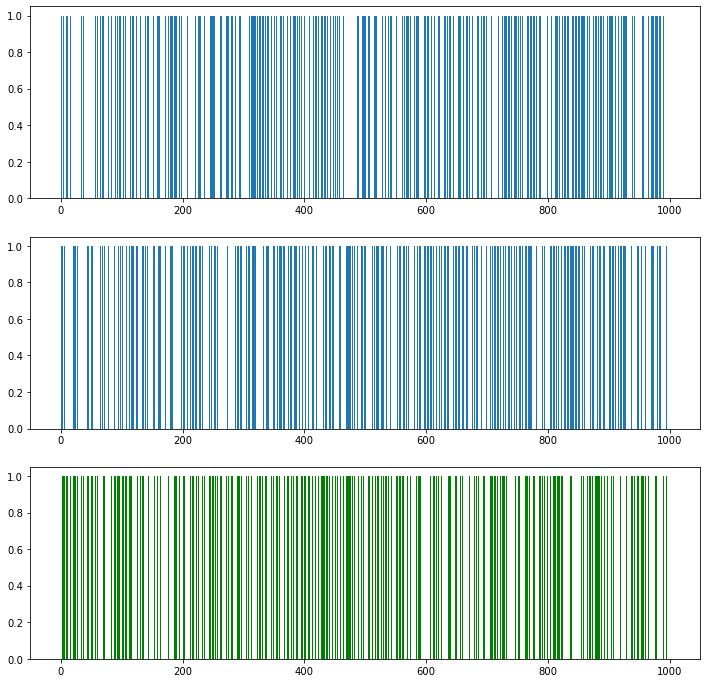

In [32]:
plot(x, g)

In [35]:
class _NetTools:
    @staticmethod
    def _packed_views(shapes, dtype=np.float32):    
        sizes = [np.product(shape) for shape in shapes]
        total_size = np.sum(sizes)

        ends = np.cumsum(sizes)
        starts = np.roll(ends, 1)
        starts[0] = 0

        packed = np.zeros(total_size, dtype=dtype)
        views = tuple(packed[start:end].reshape(shape)
                      for start, end, shape in zip(starts, ends, shapes))

        return (packed,) + views

    @staticmethod
    def _init_weight(weight):
        fan_in, fan_out = weight.shape
        bound = np.sqrt(3. / fan_in)
        weight[...] = bound * (2. * np.random.random((fan_in, fan_out)) - 1.)
        return weight
    
    @staticmethod
    def _bias(x):
        return np.concatenate((x, np.ones(x.shape[0])[:, None]), axis=1)


In [37]:
class Net(_NetTools):
    def __init__(self, in_chans, out_chans, num_hidden=10):
        self.parameters, self.hidden, self.visible = self._packed_views(
            ((in_chans + 1, num_hidden), (num_hidden + 1, out_chans)))
        self.reset_parameters()
        
    def reset_parameters(self):
        self._init_weight(self.hidden)
        self._init_weight(self.visible)

    def __call__(self, x):
        z = np.tanh(x @ self.hidden[:-1] + self.hidden[-1])
        return z @ self.visible[:-1] + self.visible[-1]
    
    def error(self, x, g):
        y = self(x)
        return np.sum((y - g)**2) / x.size
    
    def grad(self, x, g):
        grad, hidden_grad, visible_grad = self._packed_views(
            (self.hidden.shape, self.visible.shape))

        x1 = self._bias(x)
        z = np.tanh(x1 @ self.hidden)
        z1 = self._bias(z)
        z_prime = 1. - z**2
        
        y = z1 @ self.visible
        
        e = y - g
        delta = 2. * e / e.size 
        
        visible_grad[...] = z1.T @ delta
        delta = delta @ self.visible[:-1].T * z_prime

        hidden_grad[...] = x1.T @ delta

        err = np.sum(e**2) / x.size
        return err, grad

In [38]:
net = Net(2, 1, num_hidden=6)

In [39]:
net.error(x, g)

1.378356201171875

In [40]:
net.grad(x, g)

(1.3783561499669716,
 array([-0.2293,  0.051 , -0.2273, -0.4748,  0.0789, -0.4233, -0.2913,
         0.062 , -0.4632, -0.7934,  0.2847, -0.4475, -0.5409,  0.2843,
        -0.6792, -1.4801,  0.3902, -0.8716,  0.46  , -2.8253, -1.8024,
        -0.6344, -1.6717,  1.6116, -3.1314], dtype=float32))

In [41]:
#net.parameters

In [42]:
#net.hidden

In [43]:
#net.visible

In [44]:
y = net(x)
y.shape

(1000, 1)

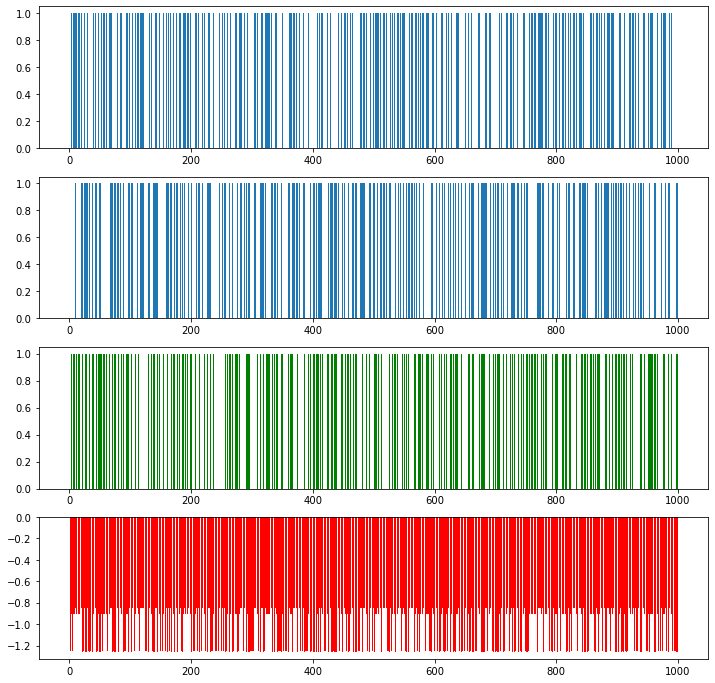

In [45]:
plot(x, g, y)

In [46]:
def spopt_error(params, x, g):
    net.parameters[...] = params
    err, grad = net.grad(x, g)
    print(err)
    return err, grad

In [47]:
##sp.optimize.minimize?

In [48]:
net.reset_parameters()

result = sp.optimize.minimize(
    spopt_error, net.parameters,
    args=(x, g),
    method='CG',
    jac=True,
    tol=1e-4,
    options={'maxiter': 100},
)

0.2249516317348317
0.749686024181379
0.18602783688897956
0.16669264677888668
0.12674736315866875
0.11524599253516689
0.10499756602948859
0.09293015699603671
0.07207960832061085
0.0839637728395262
0.049529813072277835
0.041434235685772675
0.03524832392944933
0.022405079285357465
0.020987902825574827
0.00978294940966939
0.026621792769433425
0.009446500626489511
0.00879352126875548
0.007881544066616371
0.00607724790466135
0.004633198586869335
0.0034414591854932484
0.00400207117293365
0.002651904182404856
0.0013779543937224197
0.0005230839330839057
0.0001796008680829034
0.0001892617050696272
9.497190447834125e-05
3.0332176891777024e-05
0.00018817466785004173
1.2784156321329604e-05
0.00019895921770300535
1.8693463989186708e-05
1.2627120876779944e-05
1.2400767552851286e-05
1.2017281295262362e-05
1.0556790024014856e-05
5.889279588141019e-06
6.028555631515805e-06
2.1965548624898606e-06
5.024947723361142e-06
2.2869718228010651e-07
3.0269402965717795e-07
2.290742543554674e-07
2.2612792550394185e

In [49]:
result

     fun: 1.2711714547921072e-09
     jac: array([ 1.0040e-05, -1.6664e-06, -3.6589e-07,  2.0140e-05, -3.6677e-05,
        2.5756e-07, -2.7296e-05, -7.8605e-06, -1.8732e-07,  2.4780e-06,
       -1.8817e-05, -2.5505e-06, -3.6573e-05, -2.6643e-05,  3.7276e-07,
       -1.9522e-05,  4.5478e-06, -6.9609e-06, -1.5861e-05,  1.3498e-05,
       -4.2683e-06,  1.4059e-05,  2.7304e-05,  8.7156e-06,  9.1627e-06],
      dtype=float32)
 message: 'Optimization terminated successfully.'
    nfev: 61
     nit: 25
    njev: 61
  status: 0
 success: True
       x: array([ 1.711 , -1.0342, -0.1345, -0.7378, -0.2126, -1.073 , -1.1921,
       -0.8725, -0.135 ,  0.1656, -0.9639, -0.4743,  1.0788,  0.0186,
       -0.8966, -0.1569,  0.8161, -0.2904, -1.687 , -0.9597,  0.0461,
       -1.0853,  1.3769, -0.2736,  0.2154], dtype=float32)

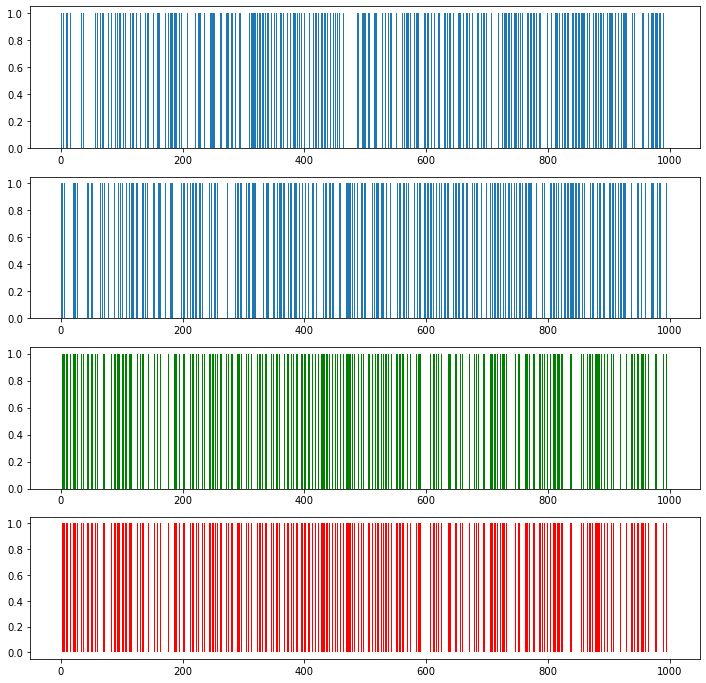

In [50]:
y = net(x)
plot(x, g, y)

In [51]:
def alopex(net, *args, step_size=0.005, forget_factor=0.01, max_iter=1_000, eps=1e-8):
    '''ALgorithm Of Pattern EXtraction (ALOPEX) 99/B version.
    '''
    # view into all of the network parameters
    params = net.parameters
    
    # initial error
    error = net.error(*args)
    error_prev = error
    error_hist = [error,]
    
    # exponentially weighted, running average of the
    # magnitude of the correlation
    corr_run = 0.
    
    # probability of taking a negative step
    probs = np.ones_like(params) * 0.5
    
    for i in (pbar := tqdm.trange(max_iter, desc='iteration')):
        # draw random steps based on probability of taking
        # a step in the negative direction
        draw = np.random.random(params.shape)
        dw = np.where(draw < probs, -step_size, step_size)
        params += dw

        # compute the error
        error_prev = error
        error = net.error(*args)
        error_hist.append(error)
        
        # current change in error
        de = error - error_prev
        
        # update the running average of the correlation
        corr_mag = np.abs(de) * np.mean(np.abs(dw))
        corr_run = (((1. - forget_factor) * corr_run) + (forget_factor * corr_mag))
        corr_run = max(corr_run, eps)
        
        # add error and running correlation to the progress bar
        pbar.set_postfix({'err': error, 'corr': corr_run})

        # correlation metric
        corr = de * dw

        # probability of taking negative step
        # is drawn from the Boltzman Distribution
        probs[...] = 1. / (1. + np.exp(-corr / corr_run))

    return munch.Munch(
        error_hist=error_hist,
    )

In [53]:
net.reset_parameters()

result = alopex(net, x, g, max_iter=1500)

iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

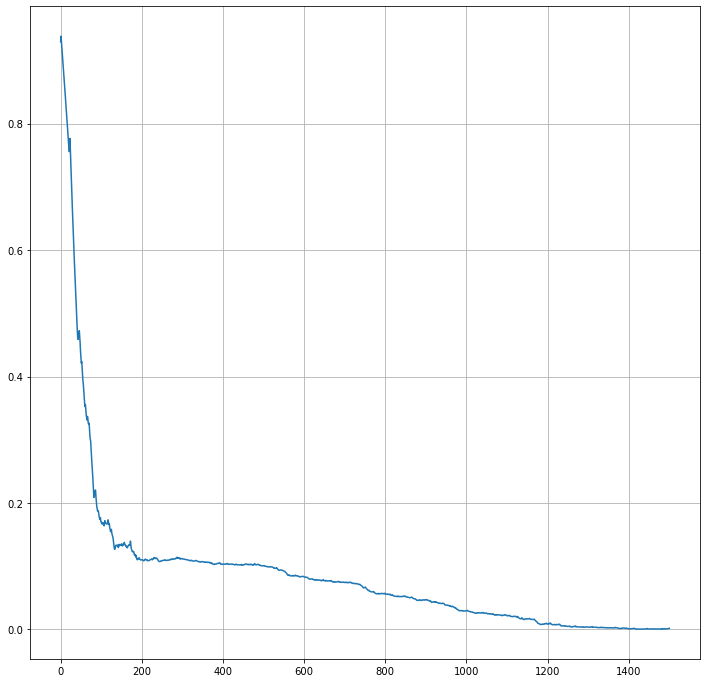

In [54]:
plt.plot(result.error_hist);
plt.grid();

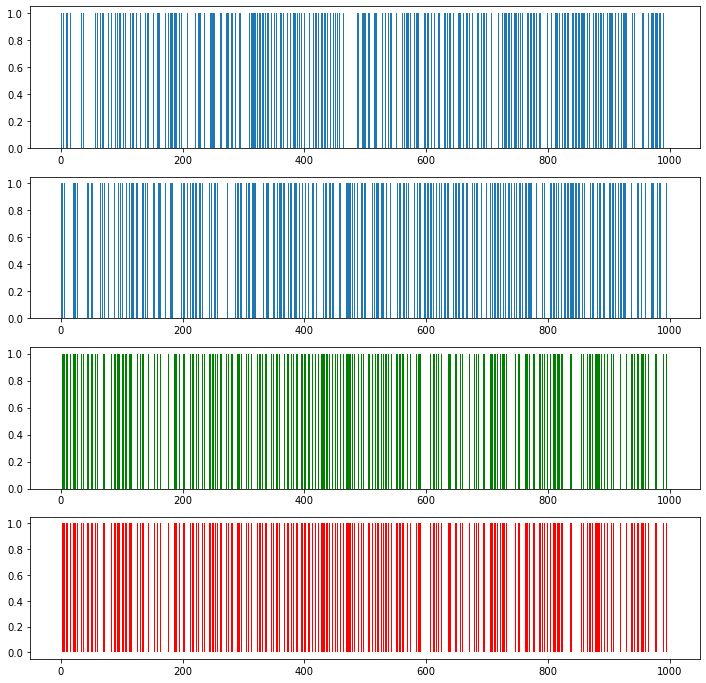

In [55]:
plot(x, g, y)